In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

# load data

In [4]:
data_dir = 'data'

In [5]:
data_network = pd.read_feather('%s/network.feather'%data_dir)
data_feature = pd.read_feather('%s/feature.feather'%data_dir)

In [6]:
n_node = len(data_feature)
n_edge = len(data_network)

In [7]:
data_network

,row,col
0,1,2
1,2,1
2,2,28
3,3,21
4,3,23
...,...,...
65666,9449,9241
65667,9449,9243
65668,9449,9439
65669,9449,9445


In [8]:
data_feature

,village,hhid,age,educ,native,work,outside,saving,shg,loan
id,,,,,,,,,,
100201,1,1002,38,2,1,1,1,0,0,0
100202,1,1002,27,2,0,0,0,0,0,0
100601,1,1006,29,7,1,1,0,0,0,0
100602,1,1006,24,10,0,1,0,1,1,0
100701,1,1007,58,10,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7516602,75,75166,32,11,0,0,0,1,1,1
7516701,75,75167,45,9,1,1,0,0,0,1
7516702,75,75167,32,9,0,0,0,1,1,1


In [9]:
Adj = sparse.csr_matrix((
    np.full(n_edge, True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
)).toarray()

In [10]:
degree = np.sum(Adj, 0)

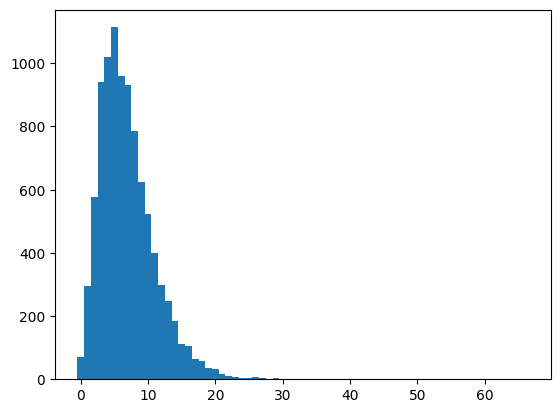

In [11]:
plt.hist(degree, np.arange(np.max(degree)+1)-0.5)
plt.show()

In [12]:
Zs = data_feature.village.values[:,None]

In [13]:
G = KECENI.Graph(Adj, Zs=Zs)

In [14]:
idx_cov = np.array([2, 3, 4, 5, 7])

In [15]:
Ys = data_feature.loan.values.astype(float)[:n_node]
Ts = data_feature.shg.values.astype(float)[:n_node]
Xs = (
    (data_feature.iloc[:n_node,idx_cov].values 
     - np.mean(data_feature.iloc[:n_node,idx_cov].values, 0))
    / np.array([100., 14., 1., 1., 1.])
)

In [16]:
data = KECENI.Data(Ys, Ts, Xs, G)

# counterfactual of interest

In [17]:
i0s = np.arange(n_node)[::20]

In [18]:
T0s_0 = np.repeat(Ts[None,:], len(i0s), 0); T0s_0[np.arange(len(i0s)), i0s] = 0
T0s_1 = np.repeat(Ts[None,:], len(i0s), 0); T0s_1[np.arange(len(i0s)), i0s] = 1

In [19]:
T0s = np.array([T0s_0, T0s_1])

# estimation

In [20]:
from KECENI.RegressionModel import KernelRegressionModel
from KECENI.PropensityModel import KernelIIDPropensityModel
from KECENI.CovariateModel import IIDCovariateModel, CommunityCovariateModel

In [21]:
from delta_fixed import delta_mu, delta_pi, delta

In [22]:
lamda_mu = 3.0
lamda_pi = 4.0
lamdas = 4.0

In [23]:
keceni_model = KECENI.Model(
    KernelRegressionModel(delta_mu, lamda=lamda_mu, ths=1e-7),
    KernelIIDPropensityModel(delta_pi, lamda=lamda_pi, ths=1e-7),
    IIDCovariateModel(),
    delta
)

## - load Fit

In [24]:
num_task = 105

In [25]:
list_fit = list()
for task_id in np.arange(num_task):
    fit_i = KECENI.Fit(
        keceni_model, data,
        **np.load('results/fit_%.3d.npz'%(task_id))
    )
    
    fit_i.xis = np.clip(fit_i.xis, 0, 1)
    
    list_fit.append(fit_i)

## - load KE

In [26]:
list_KE = [
    KECENI.KernelEstimate.KernelEstimate(
        fit_i, i0s, T0s, G,
        Ds = np.load('results/AIPW_direct_%.3d.npz'%(task_id))['Ds']
    )
    for task_id, fit_i in enumerate(list_fit) 
    if os.path.isfile('results/inf_%.3d.npz'%(task_id))
]

In [27]:
result_KE = KECENI.concat_KEs(list_KE)

In [28]:
result_KE.fit.xis = np.clip(result_KE.fit.xis, 0, 1)

In [29]:
# result_AIPW.xis = xis_tmp

In [30]:
YDRs_0, YDRs_1 = result_KE.est(lamdas)
YDRs_d = YDRs_1 - YDRs_0

## - results

In [31]:
EYDR_0 = np.mean(YDRs_0)
EYDR_1 = np.mean(YDRs_1)
EYDR_d = np.mean(YDRs_d)

In [32]:
EYDR_0, EYDR_1, EYDR_d

(0.31970112563459235, 0.4974571932575942, 0.1777560676230019)

## - plots

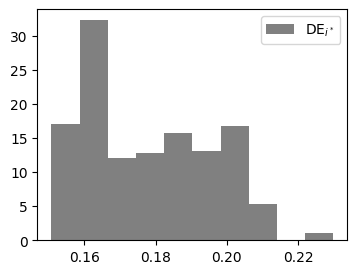

In [33]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_d, density=True, color='grey', label=r'$\mathrm{DE}_{i^*}$')
plt.legend()

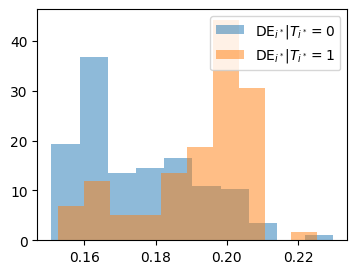

In [34]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_d[Ts[i0s]==0], alpha=0.5, density=True, label=r'$\mathrm{DE}_{i^*}|T_{i^*}=0$')
plt.hist(YDRs_d[Ts[i0s]==1], alpha=0.5, density=True, label=r'$\mathrm{DE}_{i^*}|T_{i^*}=1$')
plt.legend()

## - by village $k$ and degree $d$

In [36]:
d4 = np.minimum(np.ceil(degree[i0s]/4), 4).astype(int)

In [37]:
df_boxplot = pd.DataFrame({
    'k': G.Zs[i0s,0],
    'd': degree[i0s],
    'd4': d4,
    'YDR_d': YDRs_d
})

Text(0.5, 1.0, '')

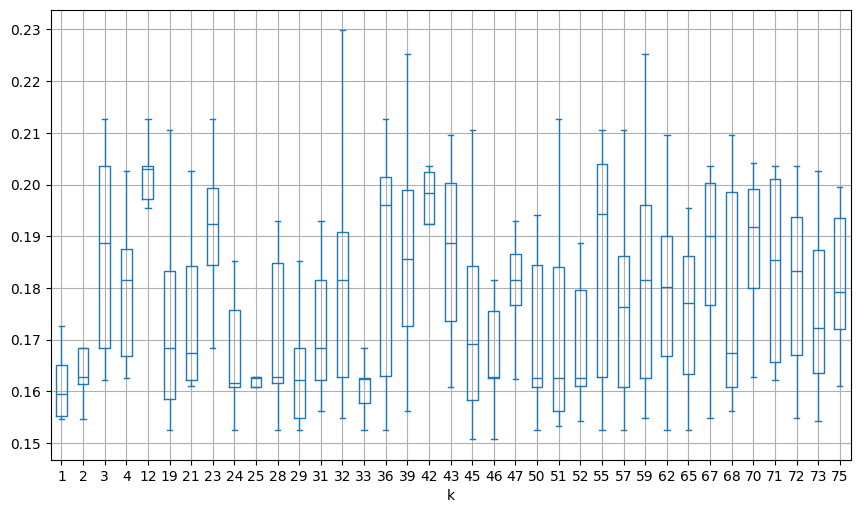

In [38]:
fig = plt.figure(figsize=(10,6)); ax = plt.gca()
df_boxplot.boxplot(column='YDR_d', by='k', ax=ax, color='C0', showfliers=False)

fig.suptitle(''); plt.title('')

Text(0.5, 1.0, '')

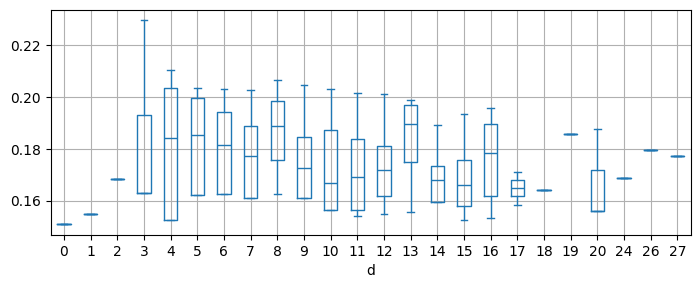

In [39]:
fig = plt.figure(figsize=(8,3)); ax = plt.gca()
bp0 = df_boxplot.boxplot(column='YDR_d', by='d', ax=ax, color='C0', 
                         showfliers=False, return_type='dict')

fig.suptitle(''); plt.title('')

Text(0.5, 1.0, '')

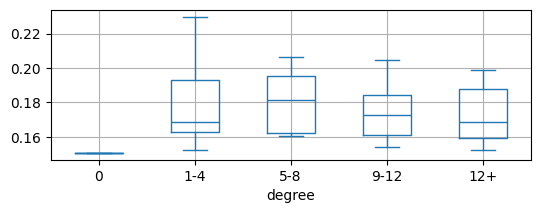

In [40]:
fig = plt.figure(figsize=(6,2)); ax = plt.gca()

bp0 = df_boxplot.boxplot(column='YDR_d', by='d4', ax=ax, color='C0', 
                         showfliers=False, return_type='dict')

ax.set_xticks([1, 2, 3, 4, 5], ['0', '1-4', '5-8', '9-12', '12+'])
ax.set_xlabel('degree')

fig.suptitle(''); plt.title('')

# inference

## - phis and Hs

In [41]:
list_Hs_nu, list_Hs_px = list(zip(*[
    dict(np.load('results/inf_%.3d.npz'%(task_id))).values()
    for task_id in range(num_task) 
    if os.path.isfile('results/inf_%.3d.npz'%(task_id))
]))

In [42]:
# list_Hs_ = [
#     H_i[result_KE.fit.js,None] for H_i in list_Hs_nu
# ]

In [43]:
# list_Hs = [
#     H_i_nu[result_KE.fit.js] + H_i_px[result_KE.fit.js] 
#     for H_i_nu, H_i_px in zip(list_Hs_nu, list_Hs_px)
# ]

In [44]:
list_phis_eif = []; list_wH = []; list_ws = []
for KE_i, H_i_nu, H_i_px in tqdm(zip(list_KE, list_Hs_nu, list_Hs_px), total=num_task):
    ws = KE_i.ws(lamdas)
    est = KE_i.est(lamdas)
    
    phis_eif = (KE_i.fit.xis.reshape((-1,)+(1,)*est.ndim) - est) * ws / np.sum(ws, 0)
    H_i = np.logical_and(KE_i.fit.xis > 0, KE_i.fit.xis < 1)[:,None] * (H_i_nu + H_i_px)
    wH_i = np.sum(H_i.reshape(H_i.shape+(1,)*est.ndim) * ws[:,None], 0) / np.sum(ws, 0)
    
    list_phis_eif.append(phis_eif)
    list_wH.append(wH_i)
    list_ws.append(np.sum(ws, 0))

100%|█████████████████████████████████████████████████████████████| 105/105 [10:10<00:00,  5.82s/it]


In [45]:
phis_sdw_dr = KECENI.concat_phis(list_ws, list_phis_eif, list_wH) # [ind_js]

In [46]:
phis_sdw_dr.shape

(9449, 2, 473)

## - distance in $\mathcal{G}$

In [47]:
from KECENI.Inference import ste_hac_sdw, bbb_sdw

In [48]:
G.get_dist()

array([[ 0.,  1.,  5., ..., inf, inf, inf],
       [ 1.,  0.,  4., ..., inf, inf, inf],
       [ 5.,  4.,  0., ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ...,  0.,  2.,  1.],
       [inf, inf, inf, ...,  2.,  0.,  2.],
       [inf, inf, inf, ...,  1.,  2.,  0.]])

In [49]:
G_sub = G.sub(result_KE.fit.js)

In [50]:
G_sub.dist = G.dist[np.ix_(result_KE.fit.js, result_KE.fit.js)]

In [51]:
G_sub.dist

array([[ 0.,  1.,  5., ..., inf, inf, inf],
       [ 1.,  0.,  4., ..., inf, inf, inf],
       [ 5.,  4.,  0., ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ...,  0.,  2.,  1.],
       [inf, inf, inf, ...,  2.,  0.,  2.],
       [inf, inf, inf, ...,  1.,  2.,  0.]])

## - results

In [52]:
phis = phis_sdw_dr

In [53]:
phis_0 = np.mean(phis[:,0,:], -1)
phis_1 = np.mean(phis[:,1,:], -1)

In [54]:
std_0 = ste_hac_sdw(phis_0, G_sub, bw=5)
std_1 = ste_hac_sdw(phis_1, G_sub, bw=5)

In [ ]:
std_d = ste_hac_sdw(phis_1 - phis_0, G_sub, bw=5)

### * confidence intervals

In [55]:
(np.mean(YDRs_0) - 2 * std_0,
 np.mean(YDRs_0) + 2 * std_0)

(0.3043273719428136, 0.3350748793263711)

In [56]:
(np.mean(YDRs_1) - 2 * std_1,
 np.mean(YDRs_1) + 2 * std_1)

(0.47120193684145517, 0.5237124496737332)

In [65]:
(np.mean(YDRs_1) - np.mean(YDRs_0) - 2 * std_d, np.mean(YDRs_1) - np.mean(YDRs_0),
 np.mean(YDRs_1) - np.mean(YDRs_0) + 2 * std_d)

(0.1544862010174467, 0.17775606762300183, 0.20102593422855697)